# 스프린트 미션 12 - A/B 테스트 분석

## 실험 개요

- 멤버십 결제 페이지 A/B 테스트를 통해 12개월 구독 유도 효과 확인
- A안: 기존안 (1개월/12개월 가격 단순 비교)
- B안: 변경안 (12개월 월간 가격 강조)

## 데이터 불러오기 및 기본 확인

- 제공된 30일간 데이터 불러오기
- A/B 그룹 여부, 구독자 수, 수익 등 주요 컬럼 확인

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np

In [2]:
df = pd.read_csv("3020Subscription%20Data.csv")
df.head(5)

,Unnamed: 0,Date,Total Users,Subscribers,1-Month Subscribers,12-Month Subscribers,Revenue,Group,Conversion Rate,1-Month Revenue,12-Month Revenue
0,0,2023.9.15,459,22,19,3,1547,A,0.047930,665,882
1,1,2023.9.16,504,26,21,5,2205,A,0.051587,735,1470
2,2,2023.9.17,514,26,22,4,1946,A,0.050584,770,1176
3,3,2023.9.18,482,23,19,4,1841,A,0.047718,665,1176
4,4,2023.9.19,512,25,19,6,2429,A,0.048828,665,1764


In [3]:
# date 컬럼이 object 인 것을 확인. 날짜 형식으로 변환 필요

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            60 non-null     int64  
 1   Date                  60 non-null     object 
 2   Total Users           60 non-null     int64  
 3   Subscribers           60 non-null     int64  
 4   1-Month Subscribers   60 non-null     int64  
 5   12-Month Subscribers  60 non-null     int64  
 6   Revenue               60 non-null     int64  
 7   Group                 60 non-null     object 
 8   Conversion Rate       60 non-null     float64
 9   1-Month Revenue       60 non-null     int64  
 10  12-Month Revenue      60 non-null     int64  
dtypes: float64(1), int64(8), object(2)
memory usage: 5.3+ KB


In [4]:
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
df.describe(include='all')

,Unnamed: 0,Date,Total Users,Subscribers,1-Month Subscribers,12-Month Subscribers,Revenue,Group,Conversion Rate,1-Month Revenue,12-Month Revenue
count,60.000000,60,60.000000,60.000000,60.000000,60.000000,60.000000,60,60.000000,60.000000,60.00000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30,NaN,NaN,NaN
mean,14.500000,2023-09-29 12:00:00,507.450000,29.666667,24.183333,5.483333,2458.516667,NaN,0.058497,846.416667,1612.10000
min,0.000000,2023-09-15 00:00:00,424.000000,20.000000,17.000000,2.000000,1323.000000,NaN,0.044944,595.000000,588.00000
25%,7.000000,2023-09-22 00:00:00,480.500000,25.000000,20.000000,4.000000,1867.250000,NaN,0.048701,700.000000,1176.00000
50%,14.500000,2023-09-29 12:00:00,512.000000,30.000000,24.000000,5.000000,2415.000000,NaN,0.055037,840.000000,1470.00000
75%,22.000000,2023-10-07 00:00:00,528.750000,35.000000,28.000000,7.000000,2924.250000,NaN,0.068341,980.000000,2058.00000
max,29.000000,2023-10-14 00:00:00,607.000000,39.000000,35.000000,11.000000,4214.000000,NaN,0.077381,1225.000000,3234.00000


A, B를 나누는 컬럼의 이름은 Group 컬럼. 각 30개의 데이터씩 위아래로 총 60개가 붙어있는 형태를 보임.

| 컬럼명 | 설명 |
|--------|------|
| Unnamed: 0 | 인덱스 컬럼 (별 의미 없음, 분석 시 제거 가능) |
| Date | 실험 일자 (2023.9.15 ~ 2023.10.14) |
| Total Users | 해당 날짜에 멤버십 결제 페이지에 방문한 사용자 수 |
| Subscribers | 해당 날짜에 실제로 구독한 사용자 수 (1개월 + 12개월 포함) |
| 1-Month Subscribers | 해당 날짜에 1개월 멤버십을 구독한 사용자 수 |
| 12-Month Subscribers | 해당 날짜에 12개월 멤버십을 구독한 사용자 수 |
| Revenue | 해당 날짜에 발생한 총 수익 (1개월 + 12개월 수익 합계) |
| Group | 실험 그룹 (A: 기존안, B: 변경안) |
| Conversion Rate | 전환율 = Subscribers / Total Users |
| 1-Month Revenue | 1개월 멤버십에서 발생한 수익 |
| 12-Month Revenue | 12개월 멤버십에서 발생한 수익 |

## 기본 지표 비교

- 그룹별 방문자 수, 구독자 수, 전환율
- 1개월 / 12개월 구독자 수 비교
- 총 수익 비교

In [6]:
# A/B 그룹별로 총합, 평균 비교
# 총 컬럼 중 Unnamed: 0, Date, Group, 을 제외한 모든 컬럼을 평균과 합을 알 수 있도록 배치
grouped = df.groupby('Group').agg({
    'Total Users': ['sum', 'mean'],
    'Subscribers': ['sum', 'mean'],
    '1-Month Subscribers': ['sum', 'mean'],
    '12-Month Subscribers': ['sum', 'mean'],
    'Revenue': ['sum', 'mean'],
    '1-Month Revenue': ['sum', 'mean'],
    '12-Month Revenue': ['sum', 'mean'],
    'Conversion Rate': ['mean']
})
grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]
grouped = grouped.reset_index()

In [7]:
# A, B, 그룹별로 각 컬럼의 총합과 평균을 구한 표.
grouped

,Group,Total Users_sum,Total Users_mean,Subscribers_sum,Subscribers_mean,1-Month Subscribers_sum,1-Month Subscribers_mean,12-Month Subscribers_sum,12-Month Subscribers_mean,Revenue_sum,Revenue_mean,1-Month Revenue_sum,1-Month Revenue_mean,12-Month Revenue_sum,12-Month Revenue_mean,Conversion Rate_mean
0,A,15265,508.833333,743,24.766667,615,20.500000,128,4.266667,59157,1971.900000,21525,717.500000,37632,1254.4,0.048621
1,B,15182,506.066667,1037,34.566667,836,27.866667,201,6.700000,88354,2945.133333,29260,975.333333,59094,1969.8,0.068373


### 기본 지표 비교 결과 요약1

> 총 방문자 수는 A/B안이 유사함 (A안: 15,265명 / B안: 15,182명)

> 총 구독자 수는 B안이 A안보다 약 39.6% 더 많음  
  - A안: 743명  
  - B안: 1,037명
  
> 12개월 구독자 수는 B안이 A안 대비 1.57배 많음
  - A안: 128명 (17.2%)  
  - B안: 201명 (19.4%)

> 전체 전환율도 B안이 A안보다 높음
  - A안 평균 전환율: 4.86%  
  - B안 평균 전환율: 6.84%

> 총 수익 기준 B안이 A안보다 약 49.3% 높음
  - A안: 59,157  
  - B안: 88,354

> 12개월 구독 수익만 비교해도 B안이 약 1.57배 많음
  - A안: 37,632  
  - B안: 59,094

> 1인당 평균 수익(ARPU)도 B안이 높을 가능성이 있음

➡ **요약**: B안은 구독 전환율, 12개월 구독 비중, 수익 면에서 모두 A안보다 우수한 성과를 보임.

In [8]:
# 총 정리된 데이터의 이거저거 추가 분석
grouped_calc = grouped.copy()

# 12개월 구독 비율 계산
grouped_calc['12M_sub_ratio'] = grouped_calc['12-Month Subscribers_sum'] / grouped_calc['Subscribers_sum']

# 1인당 평균 수익 (ARPU)
grouped_calc['ARPU'] = grouped_calc['Revenue_sum'] / grouped_calc['Total Users_sum']

# 구독자당 평균 수익
grouped_calc['Revenue_per_subscriber'] = grouped_calc['Revenue_sum'] / grouped_calc['Subscribers_sum']

# 12개월 구독자당 평균 수익
grouped_calc['12M_revenue_per_sub'] = grouped_calc['12-Month Revenue_sum'] / grouped_calc['12-Month Subscribers_sum']
grouped_calc['1M_revenue_per_sub'] = grouped_calc['1-Month Revenue_sum'] / grouped_calc['1-Month Subscribers_sum']

In [9]:
print(grouped_calc[['Group','ARPU', 'Revenue_per_subscriber', '1M_revenue_per_sub','12M_revenue_per_sub']])

  Group      ARPU  Revenue_per_subscriber  1M_revenue_per_sub  \
0     A  3.875336               79.619112                35.0   
1     B  5.819655               85.201543                35.0   

   12M_revenue_per_sub  
0                294.0  
1                294.0  


| 지표 | A안 | B안 | 해석 |
|------|-----|-----|------|
| 1인당 평균 수익 (ARPU) | 3.88 | 5.82 | *B안이 약 1.5배 더 높음* |
| 구독자당 평균 수익 | 79.62 | 85.20 | B안이 구독자 1명당 더 많은 수익을 냄 |
| 1개월 구독자당 평균 수익 | 35.0 | 35.0 | 동일한 가격 구조로 동일한 결과 |
| 12개월 구독자당 평균 수익 | 294.00 | 294.00 | 동일한 가격 구조로 동일한 결과 |


_  
  
  
B안은 방문자 1명당 수익, 구독자 1명당 수익 모두 A안보다 높았음.  
이는 12개월 구독을 효과적으로 유도하여 단기 현금 확보라는 목표에 더 부합한다고 볼 수 있음.  
+ 한 명의 구독자가 가져다주는 수익은 똑같다는 것을 가정하고 만들어진 데이터..인듯?

## 시각화

알아볼 수 있을 것 같은 것들.
1. 일자별 전환률
2. 일자별 12월 구독자 수

여기서 전환률: 방문자가 구독자로 전환된 것. 이미 계산되어서 Conversion Rate 컬럼으로 저장되어 있다.

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

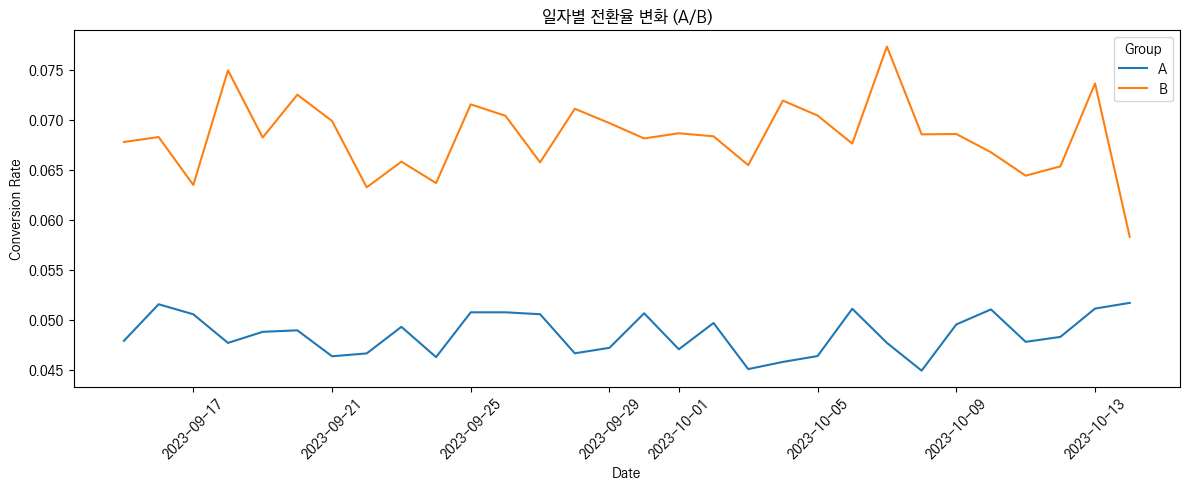

In [11]:
# 일자별 전환율
plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x='Date', y='Conversion Rate', hue='Group')
plt.title('일자별 전환율 변화 (A/B)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

일자별 전환율 변화를 보면, *안이 A안보다 전반적으로 더 높은 전환율을 유지*함.    
  
A안은 대부분 4.5% ~ 5.2% 사이의 전환율을 보인 반면,     
B안은 대부분 6.5% ~ 7.5% 사이의 전환율을 유지함.   
   
일간 편차는 있지만, 전체적으로 **B안이 안정적으로 높은 전환율을 기록**했다고 볼 수 있음.     

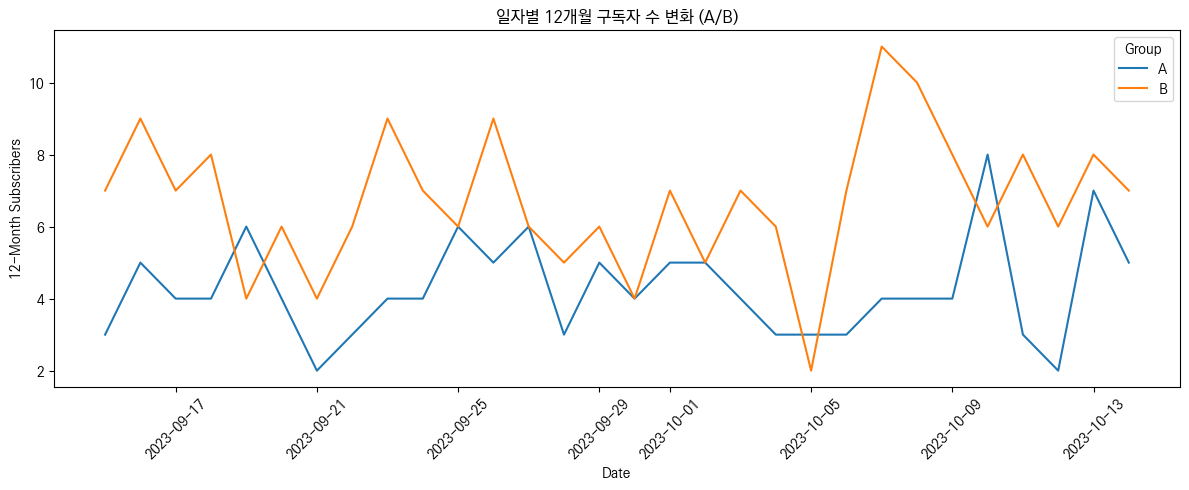

In [12]:
# 일자별 12개월 구독자 수
plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x='Date', y='12-Month Subscribers', hue='Group')
plt.title('일자별 12개월 구독자 수 변화 (A/B)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

일자별 12개월 구독자 수를 비교했을 때, B안의 값이 높은 날이 더 많음.  
   
A, B 모두 구독자 수의 변동이 큼. *그러나 B안에서 더 많은 피크 값이 나타남...*   
   
일부 날짜에서는 B안의 12개월 구독자 수가 A안보다 2배 더 높게 나타나는 경우도 보임.   

> 전반적으로 구독자 수 유도 측면에서는 B안이 더 효과적이었다고 볼 수 있을 듯.

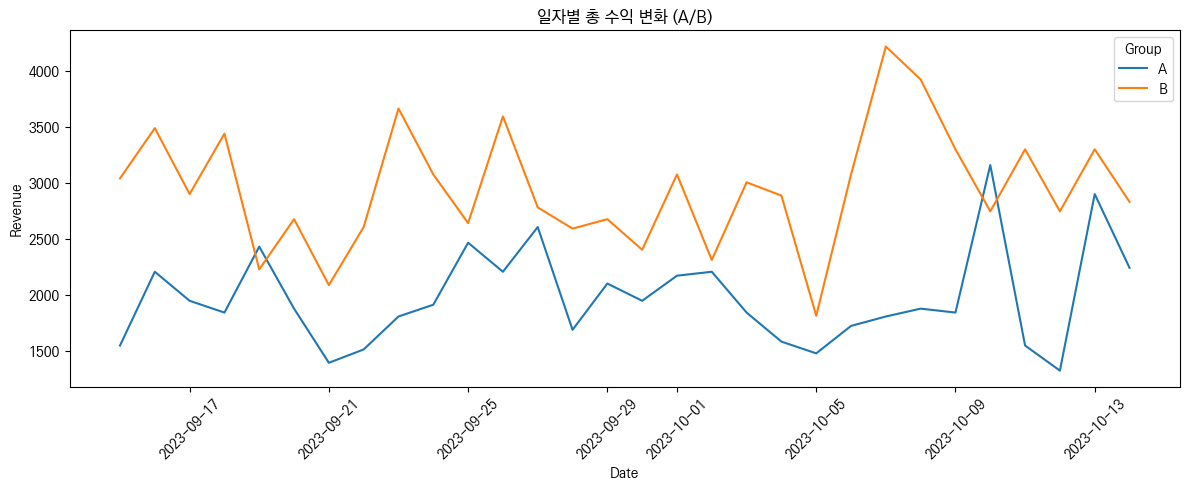

In [13]:
# 일자별 총 수익 변화
plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x='Date', y='Revenue', hue='Group')
plt.title('일자별 총 수익 변화 (A/B)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 통계 분석

- 전환율 차이 검정 (z-test)
- 12개월 구독 비율 차이 검정 (z-test)
- 평균 수익 차이 검정 (t-test)


### 전환율 차이 검정 (z-test)

In [20]:
from statsmodels.stats.proportion import proportions_ztest

# 일단 그룹별로 방문자 수랑 구독자 수 합부터
a_subs = df[df['Group'] == 'A']['Subscribers'].sum()
a_total = df[df['Group'] == 'A']['Total Users'].sum()

b_subs = df[df['Group'] == 'B']['Subscribers'].sum()
b_total = df[df['Group'] == 'B']['Total Users'].sum()

In [21]:
# z-test
count = np.array([a_subs, b_subs])   # 구독한 사람 수
nobs = np.array([a_total, b_total])  # 전체 방문자 수

zstat, pval = proportions_ztest(count, nobs)

print(f"Z-statistic: {zstat:.4f}")
print(f"P-value: {pval:.4f}")

# 결과 해석... p-value 기준으로 유의미한지 판단
if pval < 0.05:
    print("전환율 차이 유의미함. B안이 효과 있었던 듯?")
else:
    print("통계적으로 차이 없다고 봐야 할 듯.")

Z-statistic: -7.3001
P-value: 0.0000
전환율 차이 유의미함. B안이 효과 있었던 듯?


In [22]:
# p값이 0이 나와서 무언가 이상하다 생각. 
# 아래 코드를 이용하여 어디가 잘못 되었을까 생각을 해보았으나, "너무 유의미해서 0에 가까운 값이 나옴"이라는 결론이...

# A/B 그룹별 구독자 수, 방문자 수 총합 확인
summary = df.groupby('Group').agg({
    'Subscribers': 'sum',
    'Total Users': 'sum'
}).reset_index()

# 전환율 직접 계산해보기
summary['Conversion Rate'] = summary['Subscribers'] / summary['Total Users']

# 결과 출력
print(summary)

  Group  Subscribers  Total Users  Conversion Rate
0     A          743        15265         0.048673
1     B         1037        15182         0.068305


#### 전환율 차이 검정 결과
    
  
- A안 전환율: 약 4.87%
- B안 전환율: 약 6.83%
    
  
->>> z-test 결과, p-value가 0으로 나왔음.  
(실제로는 0에 아주 가까운 값인데, 그냥 0으로 출력된 거라고 보면 됨)
  
 
    즉, 두 그룹의 전환율 차이는 통계적으로 매우 유의미하다는 뜻.  
    샘플 수가 많기도 하고, 전환율 격차도 제법 나서 거의 확정적으로 차이 있다고 볼 수 있음.
  

**요약하자면:**  
> B안이 A안보다 구독 전환을 확실히 더 잘 이끌어낸다.


### 12개월 구독 비율 차이 검정 (Z-test)

In [23]:
from statsmodels.stats.proportion import proportions_ztest

# A안 12개월 구독자 수 / 전체 구독자 수
a_12m = df[df['Group'] == 'A']['12-Month Subscribers'].sum()
a_all = df[df['Group'] == 'A']['Subscribers'].sum()

# B안 12개월 구독자 수 / 전체 구독자 수
b_12m = df[df['Group'] == 'B']['12-Month Subscribers'].sum()
b_all = df[df['Group'] == 'B']['Subscribers'].sum()

# z-test
count = np.array([a_12m, b_12m])  # 12개월 구독자 수
nobs = np.array([a_all, b_all])  # 전체 구독자 수

zstat, pval = proportions_ztest(count, nobs)

print(f"Z-statistic: {zstat:.4f}")
print(f"P-value: {pval:.4f}")

# 해석은 똑같이, p-value 기준으로 유의미한 차이 있는지 봄
if pval < 0.05:
    print("B안에서 12개월 구독 선택 비율이 확실히 더 높다고 봐도 될 듯.")
else:
    print("두 그룹 간 12개월 구독 비율 차이는 애매하거나 없음.")

Z-statistic: -1.1553
P-value: 0.2480
→ 두 그룹 간 12개월 구독 비율 차이는 애매하거나 없음.


z-score 값이 -1.1443 인 것을 보아 두 그룹간의 비율 차이가 그리 크지는 않다고 판단됨.
p값이 0.5보타 크기에 귀무가설을 기각하지 못함. 
  
> 유의미한 차이라고 보기 어려움.

#### 전환률은 유의미했고, 왜 이건 아니었을까?
  
    
    - 전체 구독자 수 대비 12개월 비율은 A가 17.2%, B가 19.3% 정도로 차이가 작았음.
    - 그리고 구독자 전체 수도 743명과 1037명이라 샘플 수 자체도 작은 듯.  
    - 전환률 검정보다 덜 민감하게 반응하지 않았을까...

### 평균 수익 차이 검정 (t-test)

일반적인 t-test는 두 그룹이 모두 동일한 분산을 가진다는 가정 하에 진행됨.   
그래서 분석 전, 등분산성 검정을 먼저 실행하고자 함.

In [31]:
from scipy.stats import levene

df['ARPU'] = df['Revenue'] / df['Total Users']

arpu_a = df[df['Group'] == 'A']['ARPU']
arpu_b = df[df['Group'] == 'B']['ARPU']

# 등분산 검정
stat, pval = levene(arpu_a, arpu_b)

print(f"Levene test statistic: {stat:.4f}")
print(f"P-value: {pval:.4f}")

if pval < 0.05:
    print("두 그룹의 분산은 다름. 등분산 가정이 깨짐.")
else:
    print("두 그룹의 분산은 같다고 봐도 무방.")
    
# 참고로 등분산 감정은 p값이 0.05보다 높아야 등분산이다.

Levene test statistic: 2.0402
P-value: 0.1586
두 그룹의 분산은 같다고 봐도 무방.


In [35]:
from scipy.stats import ttest_ind

tstat, pval = ttest_ind(arpu_a, arpu_b, equal_var=False)  # Welch's t-test 사용

print(f"T-statistic: {tstat:.4f}")
print(f"P-value: {pval:.4f}")

print('웰치스 t-test')

# 해석
if pval < 0.05:
    print("ARPU 차이 통계적으로 유의미함. B안에서 더 높다고 봐도 됨.")
else:
    print("ARPU 차이는 유의미하지 않음. 확신하긴 어려움.")

T-statistic: -9.3533
P-value: 0.0000
웰치스 t-test
ARPU 차이 통계적으로 유의미함. B안에서 더 높다고 봐도 됨.


In [36]:
from scipy.stats import ttest_ind

tstat, pval = ttest_ind(arpu_a, arpu_b, equal_var=True)  # 일반 t-test도 진행해봄.

print(f"T-statistic: {tstat:.4f}")
print(f"P-value: {pval:.4f}")


print('등분산 가정 t-test')
# 해석
if pval < 0.05:
    print("ARPU 차이 통계적으로 유의미함. B안에서 더 높다고 봐도 됨.")
else:
    print("ARPU 차이는 유의미하지 않음. 확신하긴 어려움.")

T-statistic: -9.3533
P-value: 0.0000
등분산 가정 t-test
ARPU 차이 통계적으로 유의미함. B안에서 더 높다고 봐도 됨.


### ARPU 차이 검정 결과
  
  
- A안 ARPU: 약 3.88  
- B안 ARPU: 약 5.82

      t-test 결과, 두 그룹 간 ARPU(1인당 평균 수익)의 차이는 통계적으로 매우 유의미함
      참고로 ARPU의 경우, 기본 지표 비교 파트에서 구함.

      등분산 가정 t-test, Welch’s t-test 둘 다 p-value = 0.0000
      즉, 어떤 방식으로 봐도 B안이 A안보다 ARPU가 확실히 높음

> B안은 단순히 구독자 수만 많은 게 아니라, 방문자 1명당 수익도 훨씬 잘 뽑아낸다.


## 결론 및 제안

- 분석 결과 요약
- B안 채택 여부 제안

### 분석 결과 요약

1. 전환률

       B안이 A안보다 전환률이 통계적으로 높았음. (p < 0.001).  
       방문자의 구독 전환 성과에서 B안이 명확한 우위를 보임.

2. 12개월 구독 비율

       B안이 소폭 높긴 했지만, 통계적으로 유의미한 차이는 아님 (p = 0.248).  
       즉, 장기 구독 유도 효과는 확실하다고 보긴 어려움.
       
3. ARPU (1인당 평균 수익)

       B안이 A안보다 ARPU가 약 1.5배 높았고,  
       두 방식(t-test, Welch’s t-test) 모두에서 매우 유의미한 차이가 검정됨 (p < 0.001).  
       방문자당 수익 측면에서 B안의 효과는 확실히 입증.
       
       
4. 수익 전체 규모와 1개월/12개월 수익 구성 비중에서도 B안이 더 우수한 성과를 보임.

### B안 채택 권고

1. 결론,

        단기 현금 유입을 목표로 한다면, B안은 매우 효과적인 페이지 설계안임.
        특히 방문자당 수익이 유의미하게 높아졌고, 전체 수익 규모도 큰 차이를 보임.
        12개월 구독 비율 증가 자체는 확실하진 않지만,  
        전환율과 ARPU 상승만으로도 도입할 가치가 충분하다고 판단됨.
2. 따라서, 본 분석에서는 실험안 B안을 채택하는 것이 합리적이라 제안한다.
